# Source: [Andrey Kaparthy](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&ab_channel=AndrejKarpathy)

In [1]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Sequence, TypeAlias, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def f(x: int | float) -> int | float:
    """A function that generates a quadratic function."""
    result: int | float = 3 * x**2 - 4 * x + 5
    return result

In [3]:
ndArray: TypeAlias = npt.NDArray[np.int_ | np.float_]

Xs: ndArray = np.arange(-5, 5, 0.25)
Ys: ndArray = f(Xs)

Xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [4]:
Ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

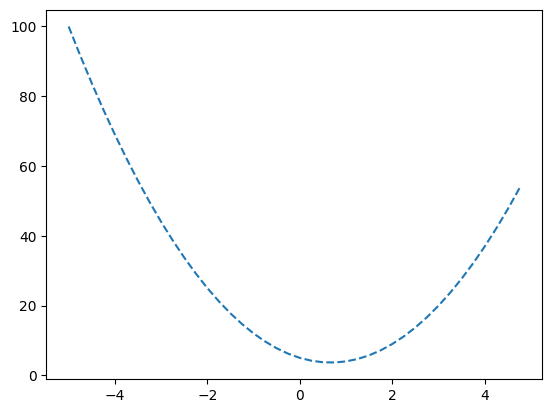

In [5]:
plt.plot(Xs, Ys, "--")
plt.show()

## Derivative

- The derivative of a function captures the idea of `instantaneous rate of change`.
- In both calculus and machine learning, it tells you how a function's output, denoted by f(x), changes with respect to its input, represented by x.

In [6]:
h: float = 0.001  # A very small number
x: float = 3.0

f(x + h)

20.014003000000002

$$ y=3x^2 -4x + 5 $$

Slope is ...

$$ slope = 6x - 4 $$

If x = 3;
$$ slope = 6(3) - 4 = 14 $$

In [7]:
# Change in value divided by run. i.e. rise per run
slope: float = (f(x + h) - f(x)) / h
slope

14.00300000000243

## Micro Grad Implementation

In [8]:
class Value:

    def __init__(
        self,
        data: int | float,
        _children: tuple[Any] = tuple(),
        _op: str = "",
        label: str = "",
    ) -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0  # No gradient yet

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(data={self.data})"

    def __add__(self, other: "Value") -> "Value":
        """Addition of two values."""
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other: "Value") -> "Value":
        """Multiplication of two values."""
        other = other if isinstance(other, Value) else Value(other)
        return Value(self.data * other.data, (self, other), "*")

    def tanh(self) -> "Value":
        """Hyperbolic tangent of value."""
        x: int | float = self.data
        tanh = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        return Value(tanh, _children=(self,), _op="tanh")

In [9]:
a = Value(data=2, label="a")
b = Value(data=6, label="b")

a, b

(Value(data=2), Value(data=6))

In [10]:
c = a + b
c.label = "c"
d = a * b
d.label = "d"

c._prev, d._prev

({Value(data=2), Value(data=6)}, {Value(data=2), Value(data=6)})

In [11]:
c._op, d._op

('+', '*')

In [12]:
# pip install graphviz or conda install graphviz
# Copied!!!
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root, format="svg", rankdir="LR"):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ["LR", "TB"]
    nodes, edges = trace(root)
    dot = Digraph(
        format=format, graph_attr={"rankdir": rankdir}
    )  # , node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(
            name=str(id(n)),
            # label="{ data %.4f | grad %.4f }" % (n.data, n.grad),
            label="{ %s | data %.4f | grad %.4f  }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

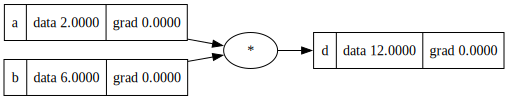

In [13]:
draw_dot(d)

In [14]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")

# Forward pass
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
L

Value(data=-8.0)

## To Do

- Derive the derivatives:
  - dL / dL
  - dL / dd
  - dL / df
  - dL / dc
  - dL / de
  - dL / da
  - dL / db


### 1. dL / dL

$$ \frac{dL}{dL} = 1 $$

### 2. dL / dd

$$ L = d * f $$
$$ \frac{dL}{dd} = \frac{ (f(x + h) - f(x) )}{h} $$
$$ \frac{dL}{dd} = \frac{ ((d+h)*f - (d*f) )}{h} $$
$$ \frac{dL}{dd} = \frac{ (d*f + h*f - d*f )}{h} $$
$$ \frac{dL}{dd} = f $$

### 3. dL / df

$$ L = d * f $$
$$ \frac{dL}{df} = \frac{ (f(x + h) - f(x) )}{h} $$
$$ \frac{dL}{df} = \frac{ (d*(f+h) - (d*f) )}{h} $$
$$ \frac{dL}{df} = d $$

### 4. dL / dc

$$ d = c + e $$
Local derivative
$$ \frac{dd}{dc} = 1 $$
Overall derivative
$$ \frac{dL}{dc} = \frac{dL}{dd} * \frac{dd}{dc} $$
$$ \frac{dL}{dc} = f * 1 $$

### 5. dL / de

$$ d = c + e $$
Local derivative
$$ \frac{dd}{de} = 1 $$
Overall derivative
$$ \frac{dL}{de} = \frac{dL}{dd} * \frac{dd}{de} $$
$$ \frac{dL}{de} = f * 1 $$

### 6. dL / da

$$ e = a * b $$
Local derivative
$$ \frac{de}{da} = b $$
Overall derivative
$$ \frac{dL}{da} = \frac{dL}{de} * \frac{de}{da} $$
$$ \frac{dL}{da} = f * b $$

### 7. dL / db

$$ e = a * b $$
Local derivative
$$ \frac{de}{db} = a $$
Overall derivative
$$ \frac{dL}{db} = \frac{dL}{de} * \frac{de}{db} $$
$$ \frac{dL}{db} = f * a $$

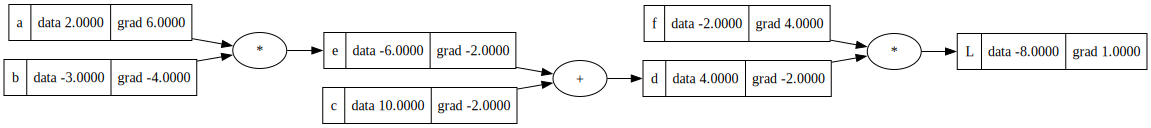

In [15]:
L.grad = 1.0  # base case
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0
e.grad = -2.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

draw_dot(L)

In [16]:
def manual_derivative() -> Any:
    """This is used to manually calculate the derivative of a function."""
    h: float = 0.0001

    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")

    # Forward pass
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L1 = L.data

    a = Value(2.0, label="a")
    a += h
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")

    # Forward pass
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L2 = L.data

    deriv: float = (L2 - L1) / h
    console.print(f"{deriv=:4f}")

In [17]:
manual_derivative()

deriv=6.000000

In [18]:
# Simulate an optimization/reduction of the loss
# i.e. add the gradients to the `leaf` nodes.
step: float = 0.01
a.data += step * a.grad
b.data += step * b.grad
c.data += step * c.grad
f.data += step * f.grad

# Forward pass
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
L  # From -8.0 to -7.44

Value(data=-7.4352)

## BackProp In Multi-Layer Perceptron (MLP)

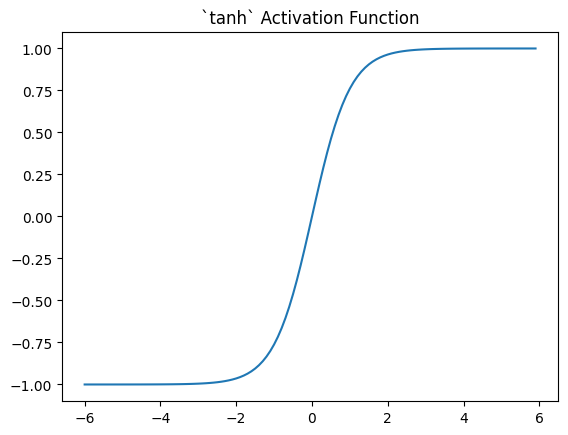

In [19]:
# Tanh activation function
X: ndArray = np.arange(-6, 6, 0.1)
Y: ndArray = np.tanh(X)

plt.plot(X, Y)
plt.title("`tanh` Activation Function")
plt.show()

In [20]:
# Updated!
class Value:

    def __init__(
        self,
        data: int | float,
        _children: tuple[Any] = tuple(),
        _op: str = "",
        label: str = "",
    ) -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0  # No gradient yet
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(data={self.data})"

    def __add__(self, other: "Value") -> "Value":
        """Addition of two values."""
        other = other if isinstance(other, Value) else Value(other)
        out: Value = Value(self.data + other.data, (self, other), "+")

        def _backward() -> None:
            """Closure for calculating gradient of an addition operation."""
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __mul__(self, other: "Value") -> "Value":
        """Multiplication of two values."""
        other = other if isinstance(other, Value) else Value(other)
        out: Value = Value(self.data * other.data, (self, other), "*")

        def _backward() -> None:
            """Closure for calculating gradient of a multiplication operation.
            NB: The input values are flipped because of the multiplication.
            """
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def tanh(self) -> "Value":
        """Hyperbolic tangent of value."""
        x: int | float = self.data
        tanh = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        out: Value = Value(tanh, _children=(self,), _op="tanh")

        def _backward() -> None:
            """Closure for calculating gradient of a hyperbolic tangent operation."""
            self.grad += (1 - tanh**2) * out.grad

        out._backward = _backward
        return out

<hr><br>

## Build A Simple MLP With Two Inputs

<img src="./images/neuron_model.jpeg" width="500">

In [21]:
def create_graph() -> list["Value"]:
    """This is used to create a graph of the forward pass."""
    # Inputs: x1, x2
    x1 = Value(2.0, label="x1")
    x2 = Value(0.0, label="x2")

    # Weights: w1, w2
    w1 = Value(-3.0, label="w1")
    w2 = Value(1.0, label="w2")

    # Bias of the neuron: b1
    b = Value(6.88131, label="b")

    # Forward pass: y = x1 * w1 + x2 * w2 + b
    x1w1 = x1 * w1
    x1w1.label = "x1w1"
    x2w2 = x2 * w2
    x2w2.label = "x2w2"
    sum_x1w1_x2w2 = x1w1 + x2w2
    sum_x1w1_x2w2.label = "x1w1 + x2w2"
    y = sum_x1w1_x2w2 + b
    y.label = "y"
    # Apply a squashing function to the output
    out = y.tanh()
    out.label = "out"

    return [out, y, sum_x1w1_x2w2, x1w1, x2w2, b, x1, x2, w1, w2, b]

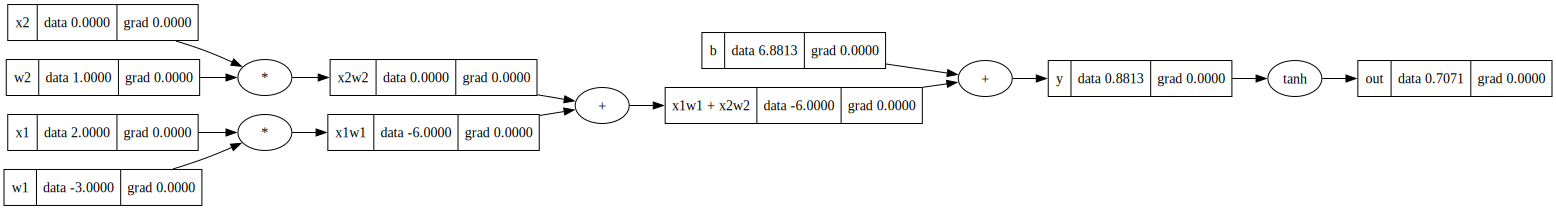

In [22]:
[out, y, sum_x1w1_x2w2, x1w1, x2w2, b, x1, x2, w1, w2, b] = create_graph()

draw_dot(out)

### Derivatives Calculations

- **Note**: The gradients of the inputs (x1, x2) are ommited since the inputs are constant and there's no need for optimizing the values.

#### 1. dout / dout

$$ out = \tanh(y) $$
$$ \frac{dout}{dout} = 1 $$

#### 2. dout / dy

$$ out = \tanh(y) $$
Chain rule
$$ \frac{dout}{dy} = \frac{dout}{dout} * \frac{dout}{dy} $$
$$ \frac{dout}{dy} = 1 * (1 - \tanh(y)^2) $$
$$ \frac{dout}{dy} = 1 - out^2 $$

#### 3. dout / (x1w1 + x2w2)

$$ y = x1*w1 + x2*w2 + b $$
Local derivative
$$ \frac{dy}{x1w1 + x2*2} = 1 $$
Overall derivative
$$ \frac{dout}{x1w1 + x2w2} = \frac{dout}{dy} * \frac{dy}{x1w1 + x2w2} $$
$$ \frac{dout}{x1w1 + x2w2} = \frac{dout}{dy} * 1 $$
$$ \frac{dout}{x1w1 + x2w2} = 1 - out^2 $$

#### 4. dout / db

$$ y = x1*w1 + x2*w2 + b $$
Local derivative
$$ \frac{dy}{b} = 1 $$
Overall derivative
$$ \frac{dout}{db} = \frac{dout}{dy} * \frac{dy}{db} $$
$$ \frac{dout}{db} = \frac{dout}{dy} * 1 $$
$$ \frac{dout}{db} = 1 - out^2 $$

#### 5. dout / d(x1w1)

$$ sumAB = x1w1 + x2w2 $$
Local derivative
$$ \frac{d(sumAB)}{d(x1w1)} = 1 $$
Overall derivative
$$ \frac{dout}{d(x1w1)} = \frac{dout}{d(sumAB)} * \frac{d(sumAB)}{d(x1w1)} $$
$$ \frac{dout}{d(x1w1)} = \frac{dout}{d(sumAB)} * 1 $$
$$ \frac{dout}{d(x1w1)} = 1 - out^2 $$

#### 6. dout / d(x2w2)

$$ sumAB = x1w1 + x2w2 $$
Local derivative
$$ \frac{d(sumAB)}{d(x2w2)} = 1 $$
Overall derivative
$$ \frac{dout}{d(x2w2)} = \frac{dout}{d(sumAB)} * \frac{d(sumAB)}{d(x2w2)} $$
$$ \frac{dout}{d(x2w2)} = \frac{dout}{d(sumAB)} * 1 $$
$$ \frac{dout}{d(x2w2)} = 1 - out^2 $$

#### 7. dout / dw1

$$ x1w1 = x1 * w1 $$
Local derivative
$$ \frac{d(x1w1)}{w1} = x1 $$
Overall derivative
$$ \frac{dout}{w1} = \frac{dout}{d(x1w1)} * \frac{d(x1w1)}{w1} $$
$$ \frac{dout}{w1} = \frac{dout}{d(x1w1)} * x1 $$
$$ \frac{dout}{w1} = (1 - out^2) * x1 $$

#### 8. dout / dw2

$$ x2w2 = x2 * w2 $$
Local derivative
$$ \frac{d(x2w2)}{w2} = x2 $$
Overall derivative
$$ \frac{dout}{w2} = \frac{dout}{d(x2w2)} * \frac{d(x2w2)}{w2} $$
$$ \frac{dout}{w2} = \frac{dout}{d(x2w2)} * x2 $$
$$ \frac{dout}{w2} = (1 - out^2) * x2 $$

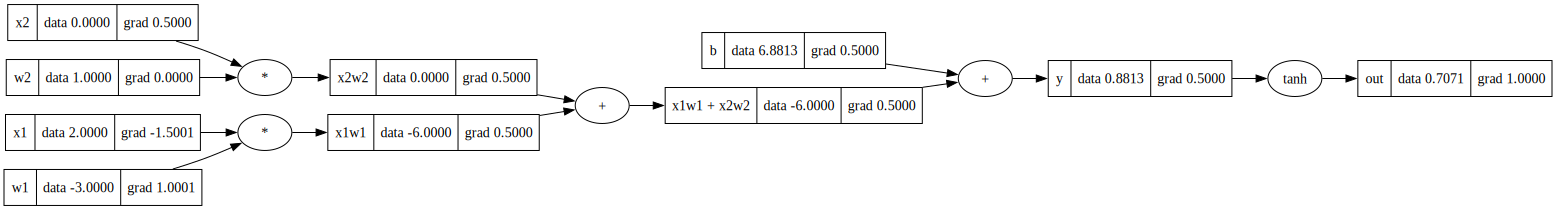

In [23]:
# Calculate Gradients
out.grad = 1.0  # Base case

# Tanh
y.grad = out.grad * (1 - out.data**2)

# Sum: Add the gradients of the output of each node to each node
sum_x1w1_x2w2.grad = y.grad
b.grad = sum_x1w1_x2w2.grad
x1w1.grad = sum_x1w1_x2w2.grad
x2w2.grad = sum_x1w1_x2w2.grad

# Multiplication: Multiply the gradient of the output by the gradient of the other input
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data
# Inputs: Optional
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data

draw_dot(out)

#### Calculate gradients using the custom class method


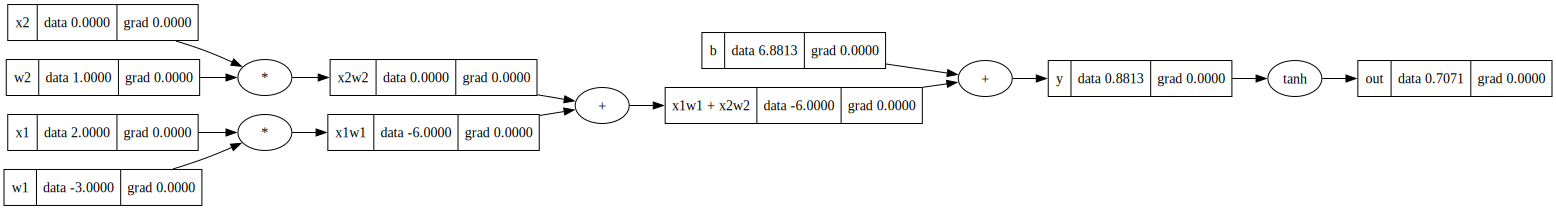

In [24]:
[out, y, sum_x1w1_x2w2, x1w1, x2w2, b, x1, x2, w1, w2, b] = create_graph()

draw_dot(out)

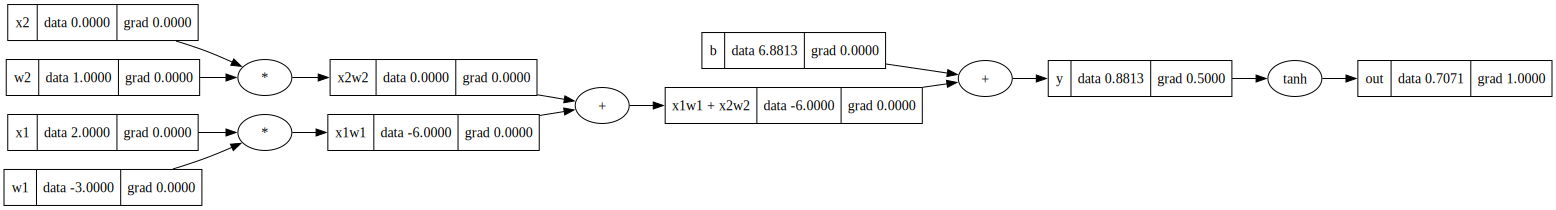

In [25]:
out.grad = 1.0  # Base case
out._backward()

draw_dot(out)

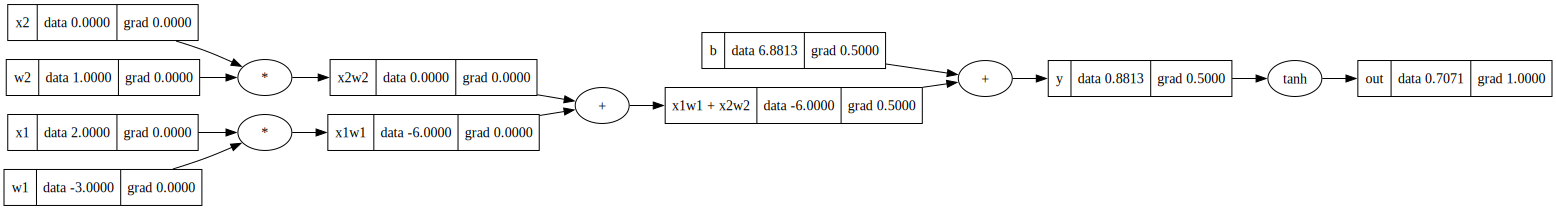

In [26]:
y._backward()

draw_dot(out)

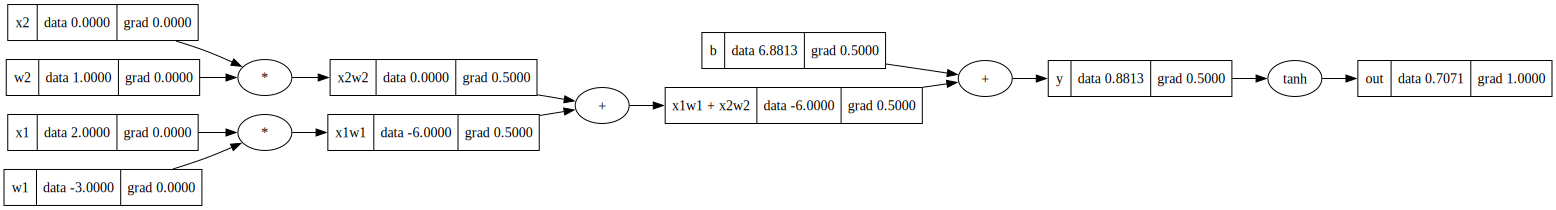

In [27]:
sum_x1w1_x2w2._backward()
b._backward()

draw_dot(out)

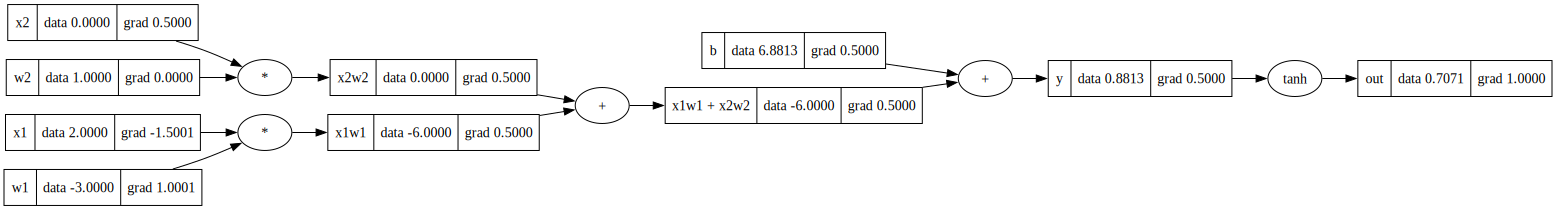

In [28]:
x1w1._backward()
x2w2._backward()

draw_dot(out)

### Implement The BackProp Without Calling It Manually

- Using topological sort.

In [29]:
def build_topology(
    node: Value, topology: list[Any] = [], visited: set[Any] = set()
) -> list[Any]:
    """Builds a topological ordering of the nodes in a directed acyclic graph (DAG).

    Params:
    -------
        node (Value): The root node of the DAG.

    Returns:
    --------
        list[Any]: A list of nodes in topological order.
    """

    if node not in visited:
        visited.add(node)
        for child in node._prev:
            build_topology(child)
        topology.append(node)
    return topology

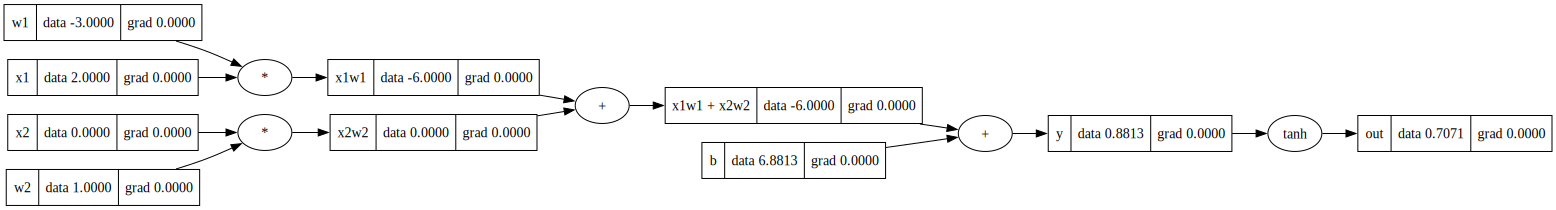

In [30]:
[out, y, sum_x1w1_x2w2, x1w1, x2w2, b, x1, x2, w1, w2, b] = create_graph()

draw_dot(out)

In [31]:
nodes: list[Any] = build_topology(node=out)
nodes

[Value(data=6.88131),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.88131),
 Value(data=0.707074986247229)]

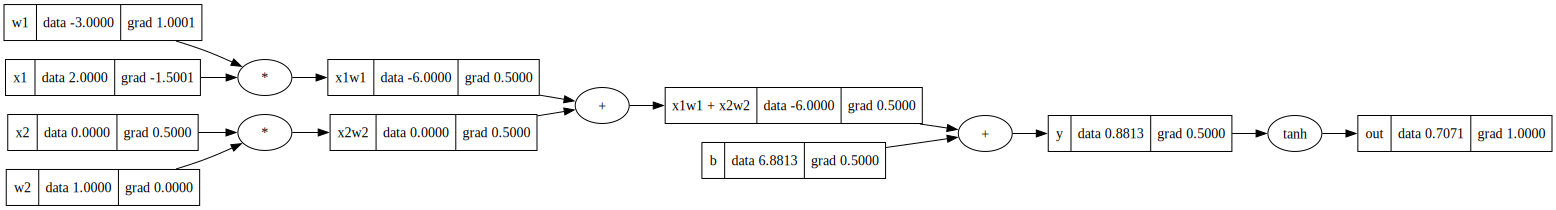

In [32]:
# Apply backprop to all the nodes in the network, starting from the output node.
out.grad = 1.0  # Base case
for node in reversed(nodes):
    node._backward()

draw_dot(out)

In [33]:
# Updated!
class Value:
    data_error: str = "only supporting int/float values"

    def __init__(
        self,
        data: int | float,
        _children: tuple[Any] = tuple(),
        _op: str = "",
        label: str = "",
    ) -> None:
        assert isinstance(data, (int, float)), self.data_error
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0  # No gradient yet
        self._backward = lambda: None

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(data={self.data})"

    def __add__(self, other: "Value") -> "Value":
        """Addition of two values."""
        other = other if isinstance(other, Value) else Value(other)
        out: Value = Value(self.data + other.data, (self, other), "+")

        def _backward() -> None:
            """Closure for calculating gradient of an addition operation."""
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __radd__(self, other: "Value") -> "Value":
        """Addition of two values. i.e. `other + self`"""
        # return self.__add__(other)
        return self + other  # This is the same as above

    def __mul__(self, other: "Value") -> "Value":
        """Multiplication of two values."""
        other = other if isinstance(other, Value) else Value(other)
        out: Value = Value(self.data * other.data, (self, other), "*")

        def _backward() -> None:
            """Closure for calculating gradient of a multiplication operation.
            NB: The input values are flipped because of the multiplication.
            """
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data

        out._backward = _backward
        return out

    def __rmul__(self, other: "Value") -> "Value":
        """Multiplication of two values. i.e. `other * self`"""
        return self * other

    def __sub__(self, other: "Value") -> "Value":
        """Subtraction of two values."""
        other = other if isinstance(other, Value) else Value(other)
        out: Value = Value(self.data + (-other.data), (self, other), "-")

        def _backward() -> None:
            """Closure for calculating gradient of a subtraction operation."""
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __neg__(self) -> int | float:
        """Negation of value."""
        return self * -1

    def __pow__(self, other: "Value") -> "Value":
        """Exponentiation of value."""
        assert isinstance(other, (int, float)), self.data_error
        other = other if isinstance(other, Value) else Value(other)
        out: Value = Value(self.data**other.data, (self,), f"**{other.data}")

        def _backward() -> None:
            """Closure for calculating gradient of an exponentiation operation."""
            self.grad += out.grad * (other.data * self.data ** (other.data - 1))

        out._backward = _backward
        return out

    def __truediv__(self, other: "Value") -> int | float:
        """Division of value. i.e. `self / other`
        Note:
        -----
            2 / 3
            2 * (1 / 3)
            2 * (3^-1)
        """
        out = self * other**-1
        return out

    def __rtruediv__(self, other: "Value") -> int | float:
        """`other / self`"""
        out = other * self**-1
        return out

    def tanh(self) -> "Value":
        """Hyperbolic tangent of value."""
        x: int | float = self.data
        tanh = (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)
        out: Value = Value(tanh, _children=(self,), _op="tanh")

        def _backward() -> None:
            """Closure for calculating gradient of a hyperbolic tangent operation."""
            self.grad += (1 - tanh**2) * out.grad

        out._backward = _backward
        return out

    def exp(self) -> "Value":
        """Exponent of value."""
        exp: int | float = np.exp(self.data)
        out: Value = Value(exp, _children=(self,), _op="exp")

        def _backward() -> None:
            """Closure for calculating gradient of an exponential operation."""
            self.grad += out.grad * exp

        out._backward = _backward
        return out

    def backward(self) -> None:
        """Propagate gradient backwards through the computation graph."""
        topology: list[Any] = []
        visited: set[Any] = set()

        def build_topology(node: Value) -> None:
            """Build a topology of the computation graph."""
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topology(child)
                topology.append(node)

        build_topology(node=self)
        # Apply backprop to all the nodes in the network, starting from the output node.
        self.grad = 1.0  # Base case
        for node in reversed(topology):
            node._backward()

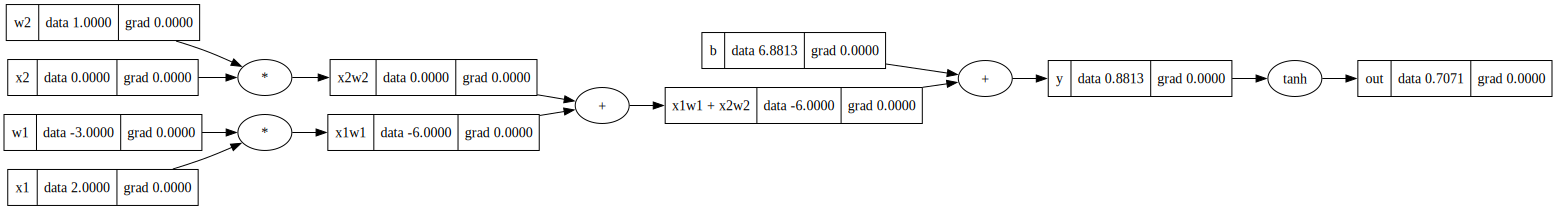

In [34]:
[out, y, sum_x1w1_x2w2, x1w1, x2w2, b, x1, x2, w1, w2, b] = create_graph()

draw_dot(out)

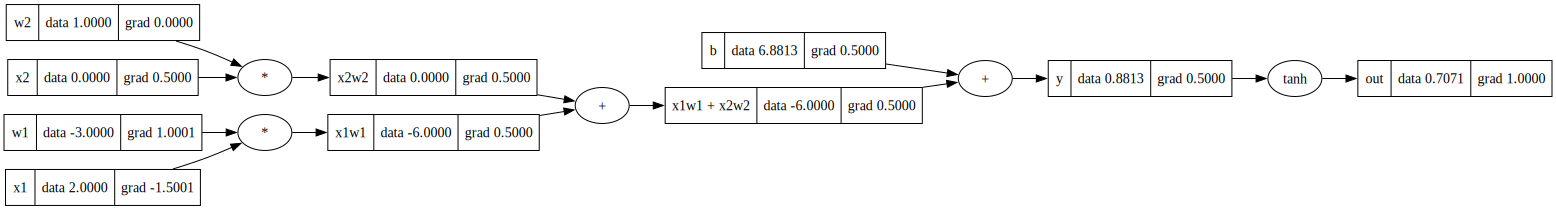

In [35]:
out.backward()
draw_dot(out)

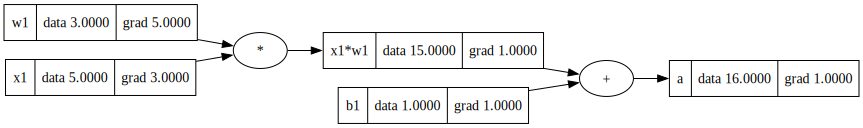

In [36]:
x1 = Value(5, label="x1")
w1 = Value(3, label="w1")
b1 = Value(1, label="b1")
x1w1 = x1 * w1
x1w1.label = "x1*w1"
a = x1w1 + b1
a.label = "a"
a.backward()
draw_dot(a)

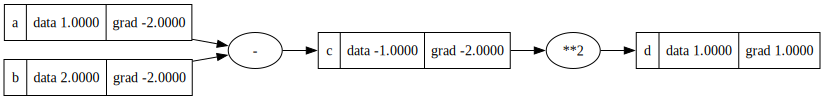

In [37]:
a = Value(1, label="a")
b = Value(2, label="b")
c = a - b
c.label = "c"
d = c**2
d.backward()
d.label = "d"
draw_dot(d)

### Recalculate the gradient using exp and power

$$ \tanh(x) = \frac{e^{2x} - 1}{e^{2x} + 1} $$

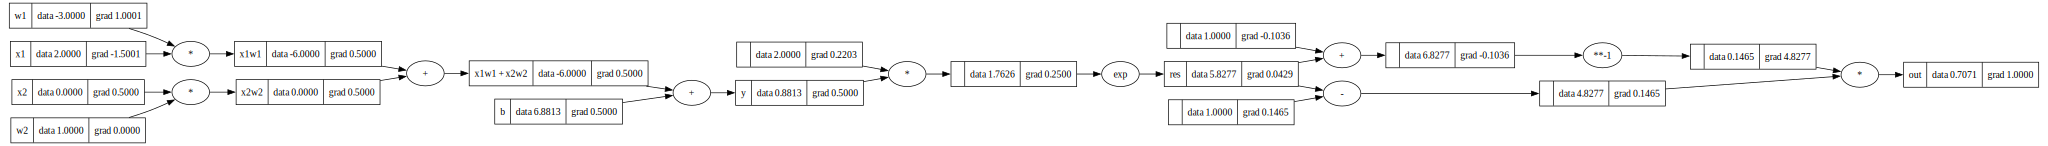

In [38]:
# Inputs: x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# Weights: w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# Bias of the neuron: b1
b = Value(6.88131, label="b")

# Forward pass: y = x1 * w1 + x2 * w2 + b
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
sum_x1w1_x2w2 = x1w1 + x2w2
sum_x1w1_x2w2.label = "x1w1 + x2w2"
y = sum_x1w1_x2w2 + b
y.label = "y"
# Apply a squashing function to the output
# out = y.tanh()
res = (2 * y).exp()
res.label = "res"
out = (res - 1) / (res + 1)
out.label = "out"
out.backward()

draw_dot(out)

## Backprop In PyTorch

In [39]:
import torch

In [40]:
# Inputs: x1, x2
x1 = torch.tensor([2.0], dtype=torch.float64, requires_grad=True)
x2 = torch.tensor([0.0], dtype=torch.float64, requires_grad=True)

# Weights: w1, w2
w1 = torch.tensor([-3.0], dtype=torch.float64, requires_grad=True)
w2 = torch.tensor([1.0], dtype=torch.float64, requires_grad=True)

# Bias of the neuron: b1
b = torch.tensor([6.88131], dtype=torch.float64, requires_grad=True)

# Forward pass: y = x1 * w1 + x2 * w2 + b
y = (x1 * w1) + (x2 * w2) + b
# Apply a squashing function to the output
out = torch.tanh(y)
print(out.item())
out.backward()

print("-------------------------------")
print("x1: ", x1.grad.item())
print("x2: ", x2.grad.item())
print("w1: ", w1.grad.item())
print("w2: ", w2.grad.item())


# draw_dot(out)

0.707074986247229
-------------------------------
x1:  -1.5001348914704429
x2:  0.500044963823481
w1:  1.000089927646962
w2:  0.0


<hr><br>

## Build A Simple MLP With Two Inputs

- Create classes for Layers and MLP.

<img src="./images/neuron_model.jpeg" width="500">

In [41]:
from micrograd.micrograd import Value
from micrograd.plot import draw_dot

In [42]:
# Create a random number from a uniform distribution
np.random.uniform(-1, 1)

-0.6141042582000236

### Neural Network

- e.g. A neural network with:
  - 3 inputs.
  - 2 hidden layers.
  - each hidden layer has 4 neurons.
  - one output layer.

<img src = "./images/neural_net2.jpeg" width=800>

In [43]:
class Neuron:
    """A single neuron."""

    def __init__(self, n_inputs: int) -> None:
        """
        Params:
        -------
            n_inputs (int): The number of inputs (weights) to each neuron in the layer.
        """
        self.weights = [
            Value(data=np.random.uniform(-1, 1)) for _ in np.arange(n_inputs)
        ]
        self.bias = Value(data=np.random.uniform(-1, 1))

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(n_inputs={len(self.weights)}, weights={self.weights}, bias={self.bias})"

    def __call__(self, x: list[Value]) -> Value:
        """This is used to perform the forward pass."""
        assert len(x) == len(
            self.weights
        ), f"Number of inputs must match number of weights. Expected {len(self.weights)} inputs, got {len(x)}"

        # w1x1 + w2x2 + ... + wnxn + b
        activation: Value = (
            np.sum((wi * xi) for wi, xi in zip(self.weights, x)) + self.bias
        )
        output: Value = activation.tanh()
        return output


class Layer:
    """A layer of neurons."""

    def __init__(self, n_inputs: int, n_outputs: int) -> None:
        """
        Params:
        -------
            n_inputs (int): The number of inputs (weights) to each neuron in the layer.
            n_outputs (int): The number of outputs (neurons) from the layer.
        """
        self.neurons = [Neuron(n_inputs) for _ in np.arange(n_outputs)]
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(n_inputs={self.n_inputs}, n_outputs={self.n_outputs})"

    def __call__(self, x: list[Value]) -> Value | list[Value]:
        """This is used to perform the forward pass of the layer."""
        output: list[Value] = [n(x) for n in self.neurons]
        return output[0] if len(output) == 1 else output


class MLP:
    """A multi-layer perceptron."""

    def __init__(self, n_inputs: int, out_layers: list[int]) -> None:
        """
        Params:
        -------
            n_inputs (int): The number of inputs (weights) to each neuron in the layer.
            out_layers (list[int]): The number of outputs (neurons) per layer. e.g. [3,3,1] would create a 3-layer MLP with 3 neurons
            in the first layer, 3 neurons in the second layer, and 1 neuron in the third layer.
        """
        assert len(out_layers) > 0, "Must have at least one layer"
        self.size = [n_inputs] + out_layers
        self.layers = [
            Layer(self.size[i], self.size[i + 1]) for i in range(len(out_layers))
        ]

    def __call__(self, x: list[Value]) -> list[Value]:
        """Forward pass through the network."""
        for layer in self.layers:
            x = layer(x)
        return x

In [44]:
X: list[Value] = [Value(1), Value(2), Value(3)]

neuron = Neuron(n_inputs=3)
console.print(f"{neuron=}", style="info")
neuron(X)

neuron=Neuron(n_inputs=3, weights=[Value(data=0.25710749524534315), Value(data=-0.4202635483805577), 
Value(data=-0.4032570231661734)], bias=Value(data=0.19310353473720543))

Value(data=-0.9216816697221247)

In [45]:
layer = Layer(n_inputs=3, n_outputs=4)
console.print(f"{layer=}", style="info")

console.print(f"layer.neurons: \n{layer.neurons}", style="info")

layer=Layer(n_inputs=3, n_outputs=4)

layer.neurons: 
[Neuron(n_inputs=3, weights=[Value(data=-0.22613683905313198), Value(data=-0.0720392489600934), 
Value(data=-0.5431252730480831)], bias=Value(data=-0.3125675800157621)), Neuron(n_inputs=3, 
weights=[Value(data=-0.9601303753483477), Value(data=0.63121878933235), Value(data=-0.6384120592919003)], 
bias=Value(data=-0.782383906768535)), Neuron(n_inputs=3, weights=[Value(data=0.055373485607696615), 
Value(data=-0.6156823606131561), Value(data=0.529054774580823)], bias=Value(data=-0.06126279244366839)), 
Neuron(n_inputs=3, weights=[Value(data=0.304932085948854), Value(data=0.4003176661932031), 
Value(data=-0.7327800971259018)], bias=Value(data=-0.6851574830619318))]

In [46]:
layer([2, 3, 4])

[Value(data=-0.996359357107369),
 Value(data=-0.9976024918357014),
 Value(data=0.3082913407691335),
 Value(data=-0.9473685998787793)]

In [47]:
X = [1, 2, 3, -2.3]

# [4, 3, 3, 1]
mlp = MLP(n_inputs=4, out_layers=[3, 3, 1])

console.print(f"mlp.layers: \n{mlp.layers}", style="info")
mlp(X)

mlp.layers: 
[Layer(n_inputs=4, n_outputs=3), Layer(n_inputs=3, n_outputs=3), Layer(n_inputs=3, n_outputs=1)]

Value(data=-0.4291956584081553)

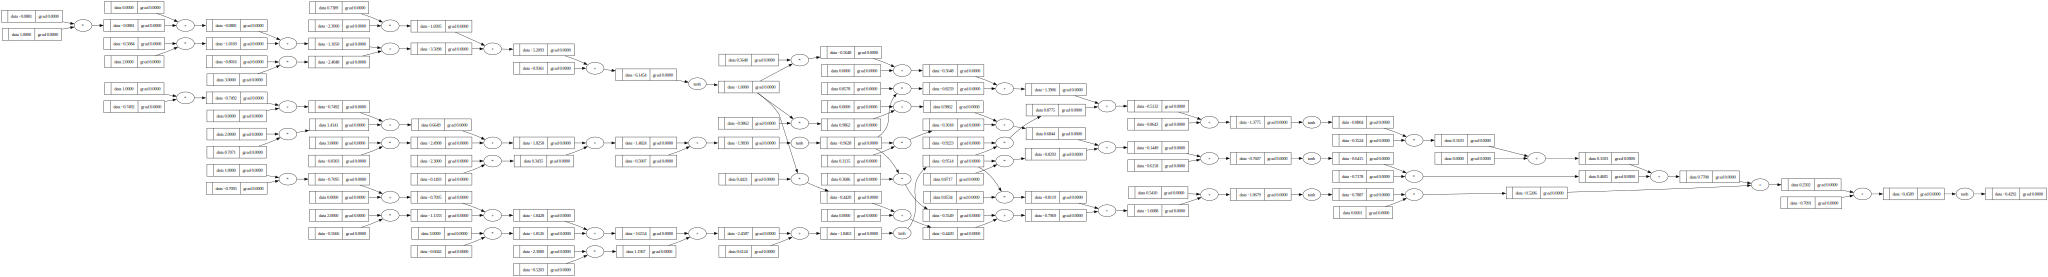

In [48]:
draw_dot(mlp(X))